# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import time
import torch
import torch.nn.functional as F

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [2]:
SEED = 9

In [3]:
# Initialize all random seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
tennisenv = "Tennis_Windows_x86_64\Tennis.exe"

In [5]:
env = UnityEnvironment(file_name=tennisenv)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print()
print()
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)

In [9]:
# Set up outside ddpg, in case we abort we can still chart...
mean_scores = []                               
moving_avgs = []
s_episode = 0
m_episode = 0

In [10]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, score_target=0.5, score_window=100, score_max=0.8):
    
    global mean_scores, moving_avgs, s_episode, m_episode
    mean_scores = []
    moving_avgs = []
    s_episode, m_episode = 0, 0
    
    best_score  = -np.inf
    scores_deque = deque(maxlen=score_window)                 # mean scores from most recent episodes - target is 100
    got_score_target = False
    sectionstarting = time.time()
    
    for i_episode in range(1, n_episodes+1):                  
        env_info = env.reset(train_mode=True)[brain_name]      # reset environment
        states = env_info.vector_observations                  # get current state for each agent
        escore = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        startingtime = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones, t, num_agents)
            
            states = next_states
            escore += rewards                                   # update the episode score (for each agent)
            if np.any(dones):
                break
                
        timetaken = int(round(time.time() - startingtime, 0))
        
        mean_escore = np.mean(escore)                          # mean of episode scores
        
        mean_scores.append(mean_escore)                        # save episode mean score
        scores_deque.append(mean_scores[-1])                   # save mean score to window of latest scores
        moving_avgs.append(np.mean(scores_deque))              # also save moving average
            
        print('\rEpisode {} ({} sec)\tCurrent Score: {:.2f}\tMean Score: {:.2f}\tMoving Average Score: {:.2f}'.format(i_episode, timetaken, mean_escore, mean_scores[-1], moving_avgs[-1]), end="")
        
        if i_episode % print_every == 0:
            last_every_avg = np.mean(mean_scores[- print_every])
            sectiontaken = int(round(time.time() - sectionstarting, 0))
            sectionstarting = time.time()
            print('\rEpisode {} ({} sec)\tCurrent Score: {:.2f}\tMean Score: {:.2f}\tMoving Average Score: {:.2f}'.format(i_episode, sectiontaken, mean_escore, last_every_avg, moving_avgs[-1]))

        if mean_escore > best_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = mean_escore
            
        if moving_avgs[-1] >= score_target and i_episode >= score_window and got_score_target==False:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-score_window, moving_avgs[-1]))
            print()
            torch.save(agent.actor_local.state_dict(), 'solved_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solved_checkpoint_critic.pth')
            s_episode = i_episode
            got_score_target=True

        if moving_avgs[-1] >= score_max and got_score_target:
            print('\nMaximum Score in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'max_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'max_checkpoint_critic.pth')
            m_episode = i_episode
            break
         
        if got_score_target:
            check_trend = moving_avgs[-10:]
            x = np.arange(0,len(check_trend))
            y = np.array(check_trend)
            z = np.polyfit(x,y,1)
            if z[0] <= -0.008:
                print('\nEarly Stopping as negative trend in scores: {:.5f}'.format(z[0]))
                break
            
                
    return mean_scores, moving_avgs, s_episode, m_episode

## Standard approach

In [11]:
start = time.time()

run_scores, run_avgs, score_episode, maxscore_episode = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (4 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 30 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 40 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 50 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 60 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 70 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 80 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 90 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 100 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 110 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 120 (9 sec)	Current Score: -0.00	Mean Score:

Episode 950 (35 sec)	Current Score: 0.20	Mean Score: 0.05	Moving Average Score: 0.255
Episode 960 (48 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.26
Episode 970 (72 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.267
Episode 980 (41 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.213
Episode 990 (81 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.22
Episode 1000 (101 sec)	Current Score: 0.10	Mean Score: 0.65	Moving Average Score: 0.22
Episode 1010 (89 sec)	Current Score: 0.15	Mean Score: 0.50	Moving Average Score: 0.23
Episode 1020 (226 sec)	Current Score: 1.00	Mean Score: 0.35	Moving Average Score: 0.28
Episode 1030 (257 sec)	Current Score: 0.30	Mean Score: 0.50	Moving Average Score: 0.37
Episode 1040 (180 sec)	Current Score: 0.40	Mean Score: 2.00	Moving Average Score: 0.41
Episode 1050 (123 sec)	Current Score: 0.90	Mean Score: 0.75	Moving Average Score: 0.45
Episode 1060 (138 sec)	Current Score: 0.40	Mean Sc

## Standard approach

In [11]:
start = time.time()

run_scores, run_avgs, score_episode, maxscore_episode = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 30 (4 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 40 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 50 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 60 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 70 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 80 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 90 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 100 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 110 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 120 (8 sec)	Current Score: -0.00	Mean Score:

Episode 950 (33 sec)	Current Score: 0.20	Mean Score: 0.05	Moving Average Score: 0.255
Episode 960 (47 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.26
Episode 970 (68 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.267
Episode 980 (39 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.213
Episode 990 (72 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.22
Episode 1000 (97 sec)	Current Score: 0.10	Mean Score: 0.65	Moving Average Score: 0.22
Episode 1010 (86 sec)	Current Score: 0.15	Mean Score: 0.50	Moving Average Score: 0.23
Episode 1020 (213 sec)	Current Score: 1.00	Mean Score: 0.35	Moving Average Score: 0.28
Episode 1030 (249 sec)	Current Score: 0.30	Mean Score: 0.50	Moving Average Score: 0.37
Episode 1040 (176 sec)	Current Score: 0.40	Mean Score: 2.00	Moving Average Score: 0.41
Episode 1050 (120 sec)	Current Score: 0.90	Mean Score: 0.75	Moving Average Score: 0.45
Episode 1060 (129 sec)	Current Score: 0.40	Mean Sco

## Experiment with Prioritized Memory Replay...

In [11]:
start = time.time()

run_scores, run_avgs, score_episode, maxscore_episode = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 30 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 40 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 50 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (8 sec)	Current Score: -0.00	Mean Score:

Episode 950 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 960 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 970 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 980 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 990 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1000 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1010 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1020 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1030 (14 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: -0.000
Episode 1040 (9 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.000
Episode 1050 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1060 (8 sec)	Current Score: -

Episode 1880 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1890 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1900 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1910 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1920 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1930 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1940 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1950 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1960 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1970 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1980 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1990 (9 sec)	Current Sco

**Result with using np.max(prio) in update_priorities:**
```
Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 30 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 40 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 50 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 170 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 190 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 200 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 210 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 220 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 230 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 240 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 250 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 260 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 270 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 280 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 290 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 300 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 310 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 320 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 330 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 340 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 350 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 360 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 370 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 380 (9 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.000
Episode 390 (12 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: -0.00
Episode 400 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 410 (10 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 420 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 430 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 440 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 450 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 460 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 470 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 480 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 490 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 500 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 510 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 520 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 530 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 540 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 550 (9 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: -0.000
Episode 560 (10 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 570 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 580 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 590 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 600 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 610 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 620 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 630 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 640 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 650 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 660 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 670 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 680 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 690 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 700 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 710 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 720 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 730 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 740 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 750 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 760 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 770 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 780 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 790 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 800 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 810 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 820 (13 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 830 (13 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.000
Episode 840 (12 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.00
Episode 850 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 860 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 870 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 880 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 890 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 900 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 910 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 920 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 930 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 940 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 950 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 960 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 970 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 980 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 990 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1000 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1010 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1020 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1030 (14 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: -0.000
Episode 1040 (9 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.000
Episode 1050 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1060 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1070 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1080 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1090 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1100 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 1110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1120 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1130 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1140 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1150 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1160 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1170 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1180 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1190 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1200 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1210 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1220 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1230 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1240 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1250 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1260 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1270 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1280 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1290 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1300 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1310 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1320 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1330 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1340 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1350 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1360 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1370 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1380 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1390 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1400 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1410 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1420 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1430 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1440 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1450 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1460 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1470 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1480 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1490 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1500 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1510 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1520 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1530 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1540 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1550 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1560 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1570 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1580 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1590 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1600 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1610 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1620 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1630 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1640 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1650 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1660 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1670 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1680 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1690 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1700 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1710 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1720 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1730 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1740 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1750 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1760 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1770 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1780 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1790 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1800 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1810 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1820 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1830 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1840 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1850 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1860 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1870 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1880 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1890 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1900 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1910 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1920 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1930 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1940 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1950 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1960 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1970 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1980 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1990 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 2000 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00

Elapsed Time: 28.48 mins.
```

**Result with using np.mean(prio) in update_priorities:**
```
Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 30 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 40 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 50 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 60 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 70 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 80 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 90 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 100 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 110 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.01
Episode 120 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 170 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 190 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 200 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 210 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 220 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 230 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 240 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 250 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 260 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 270 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 280 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 290 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 300 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 310 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 320 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 330 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 340 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 350 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 360 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 370 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 380 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 390 (14 sec)	Current Score: -0.00	Mean Score: 0.04	Moving Average Score: -0.00
Episode 400 (15 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.000
Episode 410 (18 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.00
Episode 420 (21 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 430 (13 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 440 (12 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 450 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 460 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 470 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 480 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 490 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 500 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 510 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 520 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 530 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 540 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 550 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 560 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 570 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 580 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 590 (15 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 600 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 610 (13 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 620 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 630 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 640 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 650 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 660 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 670 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 680 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 690 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 700 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 710 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 720 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 730 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 740 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 750 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 760 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 770 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 780 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 790 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 800 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 810 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 820 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 830 (13 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 840 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 850 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 860 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 870 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 880 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 890 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 900 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 910 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 920 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 930 (15 sec)	Current Score: -0.01	Mean Score: 0.05	Moving Average Score: -0.00
Episode 940 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 950 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 960 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 970 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 980 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 990 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1000 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1010 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1020 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1030 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1040 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1050 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1060 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1070 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1080 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1090 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1100 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1110 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1120 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1130 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1140 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1150 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1160 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1170 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1180 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1190 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 1197 (2 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: -0.0000
```

**Debugging issue with how priorities are stored...**
```
Episode 10 (3 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.000
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.000
Episode 24 (0 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00> g:\deeplearning\udacity\deep-reinforcement-learning\p3_collab-compet\ddpg_agent.py(171)update_priorities()
-> for idx, prio in zip(batch_indices, batch_priorities):
(Pdb) type(batch_indices)
<class 'numpy.ndarray'>
(Pdb) type(batch_priorities)
<class 'numpy.ndarray'>
(Pdb) type(self.priorities)
<class 'numpy.ndarray'>
(Pdb) self.priorities.shape
(200000,)
(Pdb) batch_indices.shape
(1024,)
(Pdb) batch_priorities.shape
(1024, 1024)
(Pdb) n
> g:\deeplearning\udacity\deep-reinforcement-learning\p3_collab-compet\ddpg_agent.py(172)update_priorities()
-> self.priorities[idx] = prio
(Pdb) self.priorities[idx]
1.0
(Pdb) prio
array([5.8160003e-05, 5.8160003e-05, 5.8160003e-05, ..., 5.8160003e-05,
       5.8160003e-05, 5.8160003e-05], dtype=float32)
(Pdb) idx
608
(Pdb) batch_indices[0]
608
(Pdb) np.mean(prio)
8.4208776e-05
(Pdb) n
ValueError: setting an array element with a sequence.
> g:\deeplearning\udacity\deep-reinforcement-learning\p3_collab-compet\ddpg_agent.py(172)update_priorities()
-> self.priorities[idx] = prio
```

## Best standard approach 

In [10]:
start = time.time()

run_scores, run_avgs, score_episode, maxscore_episode = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (2 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (4 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (7 sec)	Current Score: -0.00	Mean Score:

In [10]:
start = time.time()

run_scores, run_avgs, score_episode, maxscore_episode = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (2 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (8 sec)	Current Score: -0.00	Mean Score:

In [11]:
score_episode, maxscore_episode

(526, 554)

In [11]:
plt.rcParams['figure.figsize'] = [8, 5]

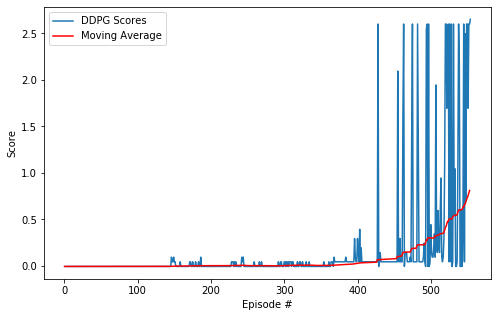

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

In [13]:
run_scores_bak = run_scores
top_avgs_bak = run_avgs

mean_scores_bak = mean_scores
moving_avgs_bak = moving_avgs

In [14]:
top_scores = run_scores[-200:]
top_avgs = run_avgs[-200:]

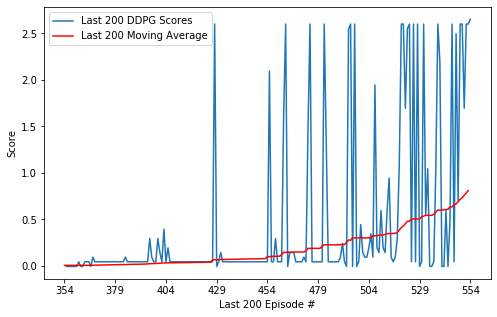

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(top_scores)+1), top_scores, label='Last 200 DDPG Scores')
plt.plot(np.arange(len(top_scores)), top_avgs, c='r', label='Last 200 Moving Average')
plt.ylabel('Score')
plt.xlabel('Last 200 Episode #')
plt.legend(loc='upper left')
plt.draw()

adjustby = len(run_scores)  - len(top_scores)
xlabels = list(ax.get_xticklabels())
newlabels = [int(item.get_position()[0] + adjustby) for item in xlabels]
ax.set_xticklabels(newlabels)
plt.show()

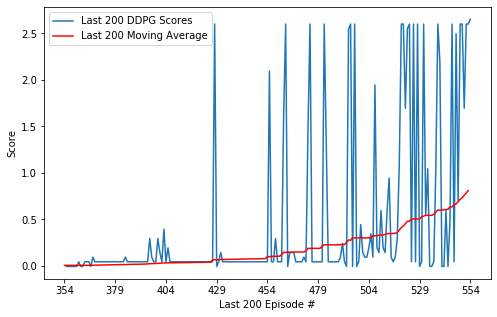

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(top_scores)+1), top_scores, label='Last 200 DDPG Scores')
plt.plot(np.arange(len(top_scores)), top_avgs, c='r', label='Last 200 Moving Average')
plt.ylabel('Score')
plt.xlabel('Last 200 Episode #')
plt.legend(loc='upper left')
plt.draw()

adjustby = len(run_scores)  - len(top_scores)
xlabels = list(ax.get_xticklabels())
newlabels = [int(item.get_position()[0] + adjustby) for item in xlabels]
ax.set_xticklabels(newlabels)
plt.show()

### Run 5
```
Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (16 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (10 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 170 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.00
Episode 190 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 200 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 210 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 220 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 230 (10 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.00
Episode 240 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 250 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 260 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 270 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 280 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 290 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 300 (12 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.00
Episode 310 (13 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 320 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 330 (13 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.011
Episode 340 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 350 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 360 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 370 (16 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.011
Episode 380 (17 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.01
Episode 390 (19 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.02
Episode 400 (30 sec)	Current Score: 0.30	Mean Score: 0.05	Moving Average Score: 0.03
Episode 410 (31 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.04
Episode 420 (18 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.04
Episode 430 (69 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.077
Episode 440 (19 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.07
Episode 450 (18 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.08
Episode 460 (66 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.11
Episode 470 (108 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.15
Episode 480 (99 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.19
Episode 490 (97 sec)	Current Score: 0.10	Mean Score: 0.05	Moving Average Score: 0.23
Episode 500 (183 sec)	Current Score: 0.45	Mean Score: 0.25	Moving Average Score: 0.30
Episode 510 (89 sec)	Current Score: 0.60	Mean Score: 0.15	Moving Average Score: 0.33
Episode 520 (136 sec)	Current Score: 2.60	Mean Score: 0.20	Moving Average Score: 0.39
Episode 526 (58 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.51
Environment solved in 426 episodes!	Average Score: 0.51

Episode 530 (318 sec)	Current Score: 0.05	Mean Score: 2.60	Moving Average Score: 0.51
Episode 540 (233 sec)	Current Score: -0.00	Mean Score: 2.60	Moving Average Score: 0.60
Episode 550 (273 sec)	Current Score: 2.60	Mean Score: -0.00	Moving Average Score: 0.72
Episode 554 (62 sec)	Current Score: 2.65	Mean Score: 2.65	Moving Average Score: 0.81
Maximum Score in 454 episodes!	Average Score: 0.81

Elapsed Time: 39.53 mins.
```

In [17]:
plt.rcParams['figure.figsize'] = [8, 5]

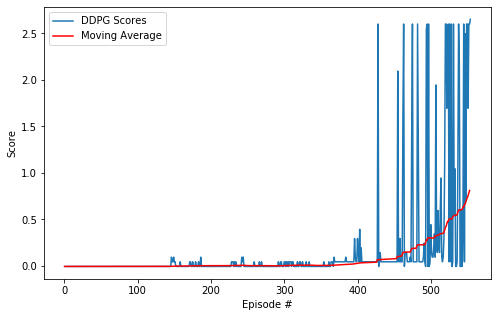

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

In [19]:
run_scores_bak = run_scores
top_avgs_bak = run_avgs

mean_scores_bak = mean_scores
moving_avgs_bak = moving_avgs

In [20]:
top_scores = run_scores[-200:]
top_avgs = run_avgs[-200:]

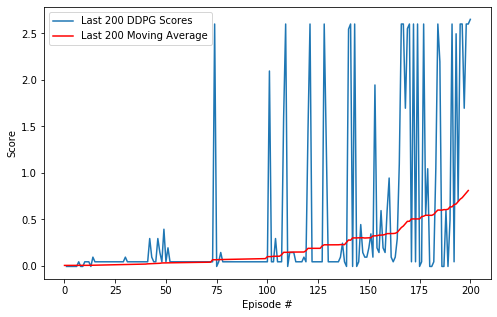

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(top_scores)+1), top_scores, label='Last 200 DDPG Scores')
plt.plot(np.arange(len(top_scores)), top_avgs, c='r', label='Last 200 Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

In [22]:
start = time.time()

run_scores, run_avgs = ddpg(score_max=1.2)

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

```
Episode 10 (189 sec)	Current Score: 0.25	Mean Score: 2.60	Moving Average Score: 0.82
Episode 20 (45 sec)	Current Score: 0.10	Mean Score: 0.55	Moving Average Score: 0.491
Episode 30 (46 sec)	Current Score: 0.10	Mean Score: -0.00	Moving Average Score: 0.38
Episode 40 (27 sec)	Current Score: 0.15	Mean Score: -0.00	Moving Average Score: 0.31
Episode 44 (3 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.312
```

In [23]:
best_avgs = moving_avgs[:583]

In [24]:
best_avgs[-1:]

[0.8028500121459365]

In [25]:
best_scores = mean_scores[:583]

In [26]:
best_scores[-1:]

[0.5450000083073974]

In [27]:
len(mean_scores), mean_scores

(1589,
 [-0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  0.04500000085681677,
  -0.004999999888241

In [28]:
moving_avgs[582]

0.8028500121459365

In [29]:
len(moving_avgs), moving_avgs

(1589,
 [-0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.0037179485870859562,
  -0.003749999869

In [30]:
best_avgs= [-0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.0037179485870859562,
  -0.0037499998696148397,
  -0.0037804876749471922,
  -0.003809523680025623,
  -0.003837209173239941,
  -0.003863636234944517,
  -0.003888888760573334,
  -0.003913043350305246,
  -0.003936170085154949,
  -0.003958333206052582,
  -0.003979591709770718,
  -0.00399999987334013,
  -0.004019607716769564,
  -0.00403846141237479,
  -0.0040566036477684975,
  -0.004074073948517993,
  -0.004090908965603872,
  -0.00410714273207954,
  -0.004122806892713956,
  -0.004137930909878221,
  -0.004152542248494544,
  -0.004166666542490324,
  -0.004180327744879683,
  -0.004193548263321,
  -0.004206349082764179,
  -0.004218749876599759,
  -0.00423076910754809,
  -0.004242424119376775,
  -0.004253731220404604,
  -0.003529411631033701,
  -0.0035507245043265648,
  -0.0035714284383824894,
  -0.003591549163028388,
  -0.003611110978656345,
  -0.003630136854130111,
  -0.0036486485167532352,
  -0.003666666535039743,
  -0.0036842103949502893,
  -0.003701298570187835,
  -0.0037179485870859562,
  -0.003734177084568935,
  -0.0031249998486600817,
  -0.002530864037481355,
  -0.0019512193436484512,
  -0.0013855419918356172,
  -0.0008333331483992792,
  -0.0008823527571033029,
  -0.000930232374907233,
  -0.0009770113118421073,
  -0.0010227270911193707,
  -0.001067415549513999,
  -0.0011111109310554133,
  -0.0011538459745409724,
  -0.001195651995342063,
  -0.001236558961932377,
  -0.001276595567531408,
  -0.0013157892972230911,
  -0.0013541664908795308,
  -0.0013917524021925386,
  -0.0014285712540909952,
  -0.001464646290799584,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.0014999998267740012,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.001999999834224582,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0024999998416751624,
  -0.0029999998584389685,
  -0.0034999998658895495,
  -0.00399999987334013,
  -0.0044999998807907105,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.0034999998658895495,
  -0.002499999850988388,
  -0.002499999850988388,
  -0.0009999998286366462,
  -0.0009999998286366462,
  -0.0004999998211860656,
  0.0005000001937150955,
  0.0015000002086162567,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0025000002235174177,
  0.0030000002309679987,
  0.0030000002309679987,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.0035000002384185792,
  0.004000000245869159,
  0.004000000245869159,
  0.004500000253319741,
  0.004500000253319741,
  0.005000000260770321,
  0.005000000260770321,
  0.005000000260770321,
  0.005500000268220902,
  0.005500000268220902,
  0.005500000268220902,
  0.006000000275671482,
  0.006500000283122063,
  0.007000000290572643,
  0.007500000298023224,
  0.008000000305473804,
  0.009000000320374965,
  0.009500000327825546,
  0.010500000342726707,
  0.011000000350177288,
  0.011500000357627868,
  0.012000000365078449,
  0.012000000365078449,
  0.01250000037252903,
  0.01350000038743019,
  0.014000000394880772,
  0.014500000402331353,
  0.015000000409781934,
  0.015500000417232514,
  0.016000000424683095,
  0.016500000432133673,
  0.017000000439584256,
  0.017500000447034834,
  0.018000000454485417,
  0.018500000461935995,
  0.019000000469386578,
  0.019500000476837157,
  0.02000000048428774,
  0.02050000049173832,
  0.0210000004991889,
  0.02145000050775707,
  0.021950000515207648,
  0.02245000052265823,
  0.02145000050775707,
  0.020950000500306487,
  0.021400000508874653,
  0.020400000493973492,
  0.020900000501424074,
  0.020900000501424074,
  0.020400000493973492,
  0.019900000486522913,
  0.01940000047907233,
  0.019900000486522913,
  0.020400000493973492,
  0.020900000501424074,
  0.021400000508874653,
  0.021900000516325235,
  0.02440000055357814,
  0.02490000056102872,
  0.0254000005684793,
  0.02590000057592988,
  0.026400000583380462,
  0.026400000583380462,
  0.02690000059083104,
  0.027400000598281623,
  0.0279000006057322,
  0.0279000006057322,
  0.0279000006057322,
  0.028400000613182784,
  0.028900000620633363,
  0.029400000628083945,
  0.029900000635534524,
  0.030400000642985106,
  0.030900000650435685,
  0.031400000657886264,
  0.031400000657886264,
  0.031900000665336846,
  0.03240000067278743,
  0.03290000068023801,
  0.033400000687688586,
  0.03390000069513917,
  0.03440000070258975,
  0.03490000071004033,
  0.035400000717490915,
  0.03490000071004033,
  0.035400000717490915,
  0.035400000717490915,
  0.035400000717490915,
  0.03590000072494149,
  0.03640000073239207,
  0.036900000739842655,
  0.03740000074729324,
  0.03740000074729324,
  0.03790000075474381,
  0.03790000075474381,
  0.03790000075474381,
  0.038400000762194395,
  0.03940000077709556,
  0.03940000077709556,
  0.039900000784546134,
  0.04040000079199672,
  0.04040000079199672,
  0.0409000007994473,
  0.0409000007994473,
  0.04140000080689788,
  0.0409000007994473,
  0.04140000080689788,
  0.041900000814348456,
  0.041900000814348456,
  0.04240000082179904,
  0.04290000082924962,
  0.04290000082924962,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.041900000814348456,
  0.041900000814348456,
  0.04140000080689788,
  0.04140000080689788,
  0.04140000080689788,
  0.04140000080689788,
  0.041900000814348456,
  0.041900000814348456,
  0.04140000080689788,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04240000082179904,
  0.04290000082924962,
  0.04290000082924962,
  0.04290000082924962,
  0.04290000082924962,
  0.04440000085160136,
  0.04440000085160136,
  0.04495000085793435,
  0.045450000865384935,
  0.045450000865384935,
  0.045450000865384935,
  0.045450000865384935,
  0.04550000086426735,
  0.04550000086426735,
  0.04550000086426735,
  0.04550000086426735,
  0.04600000087171793,
  0.04600000087171793,
  0.04650000087916851,
  0.04650000087916851,
  0.04700000088661909,
  0.04750000089406967,
  0.048000000901520255,
  0.048000000901520255,
  0.048000000901520255,
  0.048000000901520255,
  0.05050000093877315,
  0.05050000093877315,
  0.05050000093877315,
  0.051000000946223735,
  0.051000000946223735,
  0.051000000946223735,
  0.05150000095367432,
  0.052500000968575475,
  0.05300000097602606,
  0.05400000099092722,
  0.05400000099092722,
  0.05550000101327896,
  0.0570000010356307,
  0.05850000105798245,
  0.05850000105798245,
  0.061000001095235346,
  0.06250000111758709,
  0.06350000113248826,
  0.06350000113248826,
  0.06500000115483999,
  0.06650000117719174,
  0.06900000121444463,
  0.07100000124424696,
  0.0725000012665987,
  0.07300000127404928,
  0.0775000013411045,
  0.0775000013411045,
  0.07950000137090683,
  0.08000000137835742,
  0.08050000138580798,
  0.08050000138580798,
  0.08150000140070915,
  0.08500000145286321,
  0.08650000147521496,
  0.0880000014975667,
  0.08850000150501729,
  0.09000000152736902,
  0.09100000154227018,
  0.09350000157952308,
  0.09400000158697366,
  0.09550000160932541,
  0.09800000164657831,
  0.09800000164657831,
  0.09850000165402889,
  0.09900000166147947,
  0.09900000166147947,
  0.10050000168383122,
  0.10050000168383122,
  0.10200000170618295,
  0.1035000017285347,
  0.10650000177323818,
  0.10650000177323818,
  0.10650000177323818,
  0.10850000180304051,
  0.11300000187009573,
  0.11350000187754632,
  0.11450000189244747,
  0.11500000189989805,
  0.11600000191479921,
  0.1165000019222498,
  0.11750000193715096,
  0.1190000019595027,
  0.11950000196695328,
  0.11950000196695328,
  0.12050000198185444,
  0.12050000198185444,
  0.12050000198185444,
  0.12350000202655792,
  0.12500000204890965,
  0.1265000020712614,
  0.12700000207871198,
  0.12750000208616258,
  0.13000000212341548,
  0.1320000021532178,
  0.14150000229477883,
  0.14350000232458116,
  0.15000000242143868,
  0.15100000243633985,
  0.15150000244379044,
  0.16900000270456075,
  0.19455000308342277,
  0.19455000308342277,
  0.21555000339634717,
  0.21505000338889657,
  0.2355500036943704,
  0.2611000040732324,
  0.2666000041551888,
  0.2921500045340508,
  0.3076500047650188,
  0.3151500048767775,
  0.32165000497363505,
  0.324150005010888,
  0.33015000510029496,
  0.33015000510029496,
  0.33015000510029496,
  0.3476500053610653,
  0.37220000572502615,
  0.374700005762279,
  0.3837000058963895,
  0.3992000061273575,
  0.4092000062763691,
  0.41070000629872083,
  0.41070000629872083,
  0.4202000064402819,
  0.4247000065073371,
  0.4267000065371394,
  0.43120000660419466,
  0.4347000066563487,
  0.442700006775558,
  0.442700006775558,
  0.4477000068500638,
  0.44620000682771205,
  0.44620000682771205,
  0.4502000068873167,
  0.45170000690966844,
  0.45370000693947077,
  0.45270000692456963,
  0.45670000698417423,
  0.45970000702887776,
  0.4662000071257353,
  0.4657000071182847,
  0.4657000071182847,
  0.467700007148087,
  0.4682000071555376,
  0.47670000728219747,
  0.4742000072449446,
  0.48170000735670326,
  0.4807000073418021,
  0.48720000743865965,
  0.48720000743865965,
  0.4902000074833632,
  0.5077000077441335,
  0.5077000077441335,
  0.5117000078037381,
  0.5147000078484416,
  0.523700007982552,
  0.5242000079900027,
  0.5247000079974532,
  0.5242000079900027,
  0.5247000079974532,
  0.5262000080198049,
  0.5397000082209706,
  0.5527000084239989,
  0.5572000084910542,
  0.5567000084836036,
  0.5762000087741762,
  0.5842000088933855,
  0.599200009116903,
  0.6047000091988594,
  0.6157000093627721,
  0.6162000093702227,
  0.6212000094447285,
  0.6467500098235905,
  0.6527500099129975,
  0.6487500098533928,
  0.6738000102248043,
  0.6723000102024526,
  0.6748000102397055,
  0.6963000105600804,
  0.6973000105749816,
  0.7013000106345862,
  0.7078000107314437,
  0.7083000107388944,
  0.7098000107612461,
  0.715800010850653,
  0.7398000112082809,
  0.7413000112306327,
  0.7438000112678855,
  0.7508000113721937,
  0.7638000115659088,
  0.7748000117298216,
  0.7783000117819756,
  0.7853000118862837,
  0.7868000119086355,
  0.7773000117670744,
  0.7808000118192285,
  0.799850012101233,
  0.7983500120788812,
  0.8028500121459365]

In [31]:
len(best_avgs)

583

In [32]:
best_avgs = moving_avgs[:583]

In [33]:
np.mean(best_avgs[-10:])

0.7848150118784979

In [34]:
check_up_trend = best_avgs[-10:]

In [35]:
best_avgs = moving_avgs[:593]

In [36]:
np.mean(best_avgs[-10:])

0.7495750113548711

In [37]:
check_down_trend = best_avgs[-10:]

In [38]:
up_down_trend = check_up_trend + check_down_trend

In [39]:
np.mean(moving_avgs[-10:])

-0.004999999888241291

In [40]:
check_down_trend 

[0.7983500120788812,
 0.7783000117819756,
 0.7823000118415803,
 0.7623000115435571,
 0.7653000115882606,
 0.7483000113349408,
 0.729750011060387,
 0.7302500110678375,
 0.7057000107038767,
 0.6952000105474144]

In [41]:
check_trend = check_down_trend

In [42]:
x = np.arange(0,len(check_trend))
y=np.array(check_trend)
z = np.polyfit(x,y,1)
print("{0}x + {1}".format(*z))

-0.010978485011523808x + 0.7989781939067281


In [43]:
z

array([-0.01097849,  0.79897819])

In [44]:
check_trend = check_down_trend[-5:]

In [45]:
x = np.arange(0,len(check_trend))
y=np.array(check_trend)
z = np.polyfit(x,y,1)
print("{0}x + {1}".format(*z))

-0.013025000193156392x + 0.7478900113292036


In [46]:
trend = [b - a for a, b in zip(check_down_trend[::1], check_down_trend[1::1])]
trend

[-0.020050000296905623,
 0.004000000059604658,
 -0.02000000029802318,
 0.003000000044703466,
 -0.017000000253319714,
 -0.01855000027455389,
 0.0005000000074505406,
 -0.024550000363960822,
 -0.010500000156462241]

In [47]:
check_up_trend

[0.7638000115659088,
 0.7748000117298216,
 0.7783000117819756,
 0.7853000118862837,
 0.7868000119086355,
 0.7773000117670744,
 0.7808000118192285,
 0.799850012101233,
 0.7983500120788812,
 0.8028500121459365]

In [48]:
check_trend = check_up_trend

In [49]:
x = np.arange(0,len(check_trend))
y = np.array(check_trend)
z = np.polyfit(x,y,1)
zp = np.polynomial.polynomial.Polynomial.fit(x,y,1)
print("{0}x + {1}".format(*z))

0.0036427273267710877x + 0.7684227389080278


In [50]:
z

array([0.00364273, 0.76842274])

In [51]:
zp

Polynomial([0.78481501, 0.01639227], domain=[0., 9.], window=[-1.,  1.])

In [52]:
trend = [b - a for a, b in zip(check_up_trend[::1], check_up_trend[1::1])]
trend

[0.011000000163912782,
 0.0035000000521540064,
 0.007000000104308124,
 0.001500000022351733,
 -0.009500000141561049,
 0.0035000000521541175,
 0.01905000028200443,
 -0.001500000022351733,
 0.00450000006705531]

In [53]:
up_down_trend

[0.7638000115659088,
 0.7748000117298216,
 0.7783000117819756,
 0.7853000118862837,
 0.7868000119086355,
 0.7773000117670744,
 0.7808000118192285,
 0.799850012101233,
 0.7983500120788812,
 0.8028500121459365,
 0.7983500120788812,
 0.7783000117819756,
 0.7823000118415803,
 0.7623000115435571,
 0.7653000115882606,
 0.7483000113349408,
 0.729750011060387,
 0.7302500110678375,
 0.7057000107038767,
 0.6952000105474144]

In [54]:
check_trend = up_down_trend

In [55]:
x = np.arange(0,len(check_trend))
y=np.array(check_trend)
z = np.polyfit(x,y,1)
print("{0}x + {1}".format(*z))

-0.0035596993010126826x + 0.8010121549763048


In [56]:
z

array([-0.0035597 ,  0.80101215])

In [57]:
trend = [b - a for a, b in zip(up_down_trend[::1], up_down_trend[1::1])]
trend

[0.011000000163912782,
 0.0035000000521540064,
 0.007000000104308124,
 0.001500000022351733,
 -0.009500000141561049,
 0.0035000000521541175,
 0.01905000028200443,
 -0.001500000022351733,
 0.00450000006705531,
 -0.00450000006705531,
 -0.020050000296905623,
 0.004000000059604658,
 -0.02000000029802318,
 0.003000000044703466,
 -0.017000000253319714,
 -0.01855000027455389,
 0.0005000000074505406,
 -0.024550000363960822,
 -0.010500000156462241]

NameError: name 'run_scores' is not defined

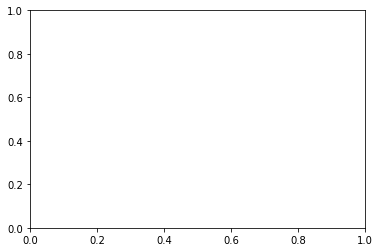

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

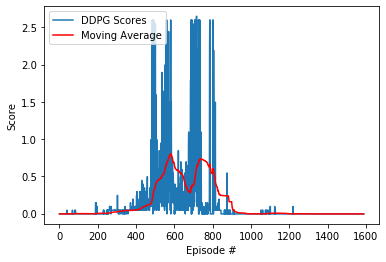

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(mean_scores)+1), mean_scores, label='DDPG Scores')
plt.plot(np.arange(len(mean_scores)), moving_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

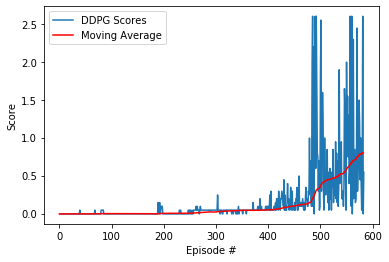

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(best_scores)+1), best_scores, label='DDPG Scores')
plt.plot(np.arange(len(best_scores)), best_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

### Run 4
```
Episode 10 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (13 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (12 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (15 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.00
Episode 100 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 170 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 190 (17 sec)	Current Score: 0.10	Mean Score: -0.00	Moving Average Score: -0.00
Episode 200 (24 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 210 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 220 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 230 (11 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.00
Episode 240 (11 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 250 (15 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 260 (18 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.011
Episode 270 (25 sec)	Current Score: 0.10	Mean Score: 0.05	Moving Average Score: 0.011
Episode 280 (23 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.02
Episode 290 (24 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.02
Episode 300 (23 sec)	Current Score: 0.05	Mean Score: 0.04	Moving Average Score: 0.02
Episode 310 (26 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.033
Episode 320 (19 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.033
Episode 330 (18 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.03
Episode 340 (19 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.04
Episode 350 (20 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.04
Episode 360 (19 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.04
Episode 370 (22 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.04
Episode 380 (24 sec)	Current Score: 0.10	Mean Score: 0.15	Moving Average Score: 0.04
Episode 390 (30 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.05
Episode 400 (27 sec)	Current Score: 0.10	Mean Score: 0.05	Moving Average Score: 0.05
Episode 410 (36 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.05
Episode 420 (45 sec)	Current Score: 0.30	Mean Score: 0.10	Moving Average Score: 0.06
Episode 430 (63 sec)	Current Score: 0.45	Mean Score: 0.15	Moving Average Score: 0.08
Episode 440 (48 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.09
Episode 450 (50 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.10
Episode 460 (56 sec)	Current Score: 0.10	Mean Score: 0.15	Moving Average Score: 0.11
Episode 470 (42 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.12
Episode 480 (89 sec)	Current Score: 0.30	Mean Score: 0.15	Moving Average Score: 0.14
Episode 490 (336 sec)	Current Score: 2.60	Mean Score: 0.70	Moving Average Score: 0.26
Episode 500 (253 sec)	Current Score: 1.85	Mean Score: 0.60	Moving Average Score: 0.35
Episode 510 (242 sec)	Current Score: 0.25	Mean Score: 2.55	Moving Average Score: 0.43
Episode 520 (117 sec)	Current Score: 0.50	Mean Score: 0.55	Moving Average Score: 0.45
Episode 530 (116 sec)	Current Score: 0.20	Mean Score: 0.05	Moving Average Score: 0.47
Episode 536 (50 sec)	Current Score: 1.90	Mean Score: 1.90	Moving Average Score: 0.51
Environment solved in 436 episodes!	Average Score: 0.51

Episode 540 (181 sec)	Current Score: 0.95	Mean Score: 0.80	Moving Average Score: 0.52
Episode 550 (189 sec)	Current Score: 2.00	Mean Score: 0.20	Moving Average Score: 0.58
Episode 560 (313 sec)	Current Score: 2.60	Mean Score: 0.95	Moving Average Score: 0.67
Episode 570 (213 sec)	Current Score: 2.45	Mean Score: -0.00	Moving Average Score: 0.74
Episode 580 (194 sec)	Current Score: 0.65	Mean Score: 0.30	Moving Average Score: 0.78
```

### Run 3
```
Episode 10 (4 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (4 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (16 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (9 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: -0.000
Episode 170 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.00
Episode 190 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 200 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 210 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 220 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 230 (10 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.00
Episode 240 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 250 (12 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 260 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 270 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 280 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 290 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.00
Episode 300 (12 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.00
Episode 310 (13 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 320 (11 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 330 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.011
Episode 340 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 350 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 360 (10 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 370 (15 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.011
Episode 380 (16 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.01
Episode 390 (17 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.02
Episode 400 (28 sec)	Current Score: 0.30	Mean Score: 0.05	Moving Average Score: 0.03
Episode 410 (28 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.04
Episode 420 (16 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.04
Episode 430 (66 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.077
Episode 440 (18 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.07
Episode 450 (17 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.08
Episode 460 (63 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.11
Episode 470 (102 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.15
Episode 480 (96 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.19
Episode 490 (93 sec)	Current Score: 0.10	Mean Score: 0.05	Moving Average Score: 0.23
Episode 500 (180 sec)	Current Score: 0.45	Mean Score: 0.25	Moving Average Score: 0.30
Episode 510 (85 sec)	Current Score: 0.60	Mean Score: 0.15	Moving Average Score: 0.33
Episode 520 (128 sec)	Current Score: 2.60	Mean Score: 0.20	Moving Average Score: 0.39
Episode 526 (82 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.51
Environment solved in 426 episodes!	Average Score: 0.51

Episode 527 (1 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.51
Episode 528 (59 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.51
Episode 529 (0 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.51
Episode 530 (358 sec)	Current Score: 0.05	Mean Score: 2.60	Moving Average Score: 0.51
Episode 531 (57 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.53
Episode 532 (12 sec)	Current Score: 0.55	Mean Score: 0.55	Moving Average Score: 0.54
Episode 533 (24 sec)	Current Score: 1.05	Mean Score: 1.05	Moving Average Score: 0.55
Episode 534 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.54
Episode 535 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.54
Episode 536 (2 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.54
Episode 537 (24 sec)	Current Score: 1.05	Mean Score: 1.05	Moving Average Score: 0.55
Episode 538 (56 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.58
Episode 539 (49 sec)	Current Score: 2.20	Mean Score: 2.20	Moving Average Score: 0.60
Episode 540 (227 sec)	Current Score: -0.00	Mean Score: 2.60	Moving Average Score: 0.60
Episode 541 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.60
Episode 542 (14 sec)	Current Score: 0.60	Mean Score: 0.60	Moving Average Score: 0.61
Episode 543 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.61
Episode 544 (12 sec)	Current Score: 0.50	Mean Score: 0.50	Moving Average Score: 0.61
Episode 545 (59 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.64
Episode 546 (1 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.64
Episode 547 (54 sec)	Current Score: 2.50	Mean Score: 2.50	Moving Average Score: 0.66
Episode 548 (15 sec)	Current Score: 0.70	Mean Score: 0.70	Moving Average Score: 0.67
Episode 549 (56 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.69
Episode 550 (269 sec)	Current Score: 2.60	Mean Score: -0.00	Moving Average Score: 0.72
Episode 551 (37 sec)	Current Score: 1.70	Mean Score: 1.70	Moving Average Score: 0.73
Episode 552 (57 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.76
Episode 553 (56 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.78
Episode 554 (58 sec)	Current Score: 2.65	Mean Score: 2.65	Moving Average Score: 0.81
Episode 555 (56 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.82
Episode 556 (1 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.82
Episode 557 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.82
Episode 558 (56 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.84
Episode 559 (30 sec)	Current Score: 1.35	Mean Score: 1.35	Moving Average Score: 0.85
Episode 560 (372 sec)	Current Score: 0.75	Mean Score: 1.70	Moving Average Score: 0.86
Episode 561 (2 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.86
Episode 562 (7 sec)	Current Score: 0.30	Mean Score: 0.30	Moving Average Score: 0.85
Episode 563 (5 sec)	Current Score: 0.20	Mean Score: 0.20	Moving Average Score: 0.82
Episode 564 (6 sec)	Current Score: 0.25	Mean Score: 0.25	Moving Average Score: 0.83
Episode 565 (12 sec)	Current Score: 0.55	Mean Score: 0.55	Moving Average Score: 0.83
Episode 566 (6 sec)	Current Score: 0.25	Mean Score: 0.25	Moving Average Score: 0.83
Episode 567 (6 sec)	Current Score: 0.25	Mean Score: 0.25	Moving Average Score: 0.83
Episode 568 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.83
Episode 569 (4 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.83
Episode 570 (53 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.83
Episode 571 (2 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.83
Episode 572 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.83
Episode 573 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.83
Episode 574 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.82
Episode 575 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.79
Episode 576 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.79
Episode 577 (6 sec)	Current Score: 0.25	Mean Score: 0.25	Moving Average Score: 0.80
Episode 578 (8 sec)	Current Score: 0.35	Mean Score: 0.35	Moving Average Score: 0.80
Episode 579 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.80
Episode 580 (36 sec)	Current Score: 0.10	Mean Score: 0.05	Moving Average Score: 0.80
Episode 581 (9 sec)	Current Score: 0.40	Mean Score: 0.40	Moving Average Score: 0.80
Episode 582 (2 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.78
Episode 583 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.77
Episode 584 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.77
Episode 585 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.77
Episode 586 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.77
Episode 587 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.77
Episode 588 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.77
Episode 589 (5 sec)	Current Score: 0.20	Mean Score: 0.20	Moving Average Score: 0.77
Episode 590 (31 sec)	Current Score: -0.00	Mean Score: 0.40	Moving Average Score: 0.77
Episode 591 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.76
Episode 592 (3 sec)	Current Score: 0.10	Mean Score: 0.10	Moving Average Score: 0.77
Episode 593 (5 sec)	Current Score: 0.20	Mean Score: 0.20	Moving Average Score: 0.77
Episode 594 (4 sec)	Current Score: 0.15	Mean Score: 0.15	Moving Average Score: 0.74
Episode 595 (11 sec)	Current Score: 0.50	Mean Score: 0.50	Moving Average Score: 0.72
Episode 596 (6 sec)	Current Score: 0.25	Mean Score: 0.25	Moving Average Score: 0.72
Episode 597 (15 sec)	Current Score: 0.70	Mean Score: 0.70	Moving Average Score: 0.71
Episode 598 (3 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.71
Episode 599 (7 sec)	Current Score: 0.30	Mean Score: 0.30	Moving Average Score: 0.71
Episode 600 (58 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.70
```

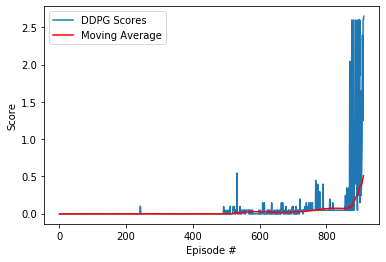

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

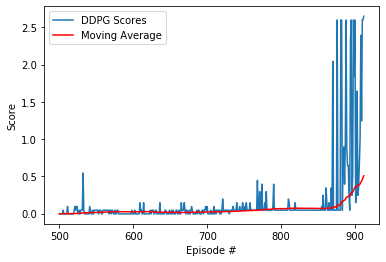

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(500, len(run_scores)+1), run_scores[-413:], label='DDPG Scores')
plt.plot(np.arange(500, len(run_scores)+1), run_avgs[-413:], c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

### Run 2
```
Episode 10 (2 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 170 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 190 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 200 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 210 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 220 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 230 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 240 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 250 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 260 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 270 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 280 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 290 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 300 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 310 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 320 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 330 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 340 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 350 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 360 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 370 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 380 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 390 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 400 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 410 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 420 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 430 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 440 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 450 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 460 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 470 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 480 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 490 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 500 (9 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 510 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 520 (7 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: -0.0000
Episode 530 (11 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.000
Episode 540 (13 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 550 (10 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.021
Episode 560 (9 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.0202
Episode 570 (10 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.02
Episode 580 (8 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.033
Episode 590 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.03
Episode 600 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 610 (8 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.032
Episode 620 (8 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.033
Episode 630 (8 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.022
Episode 640 (7 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.022
Episode 650 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 660 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 670 (11 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.02
Episode 680 (9 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.022
Episode 690 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 700 (10 sec)	Current Score: 0.10	Mean Score: -0.00	Moving Average Score: 0.02
Episode 710 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 720 (9 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.0202
Episode 730 (12 sec)	Current Score: -0.00	Mean Score: 0.20	Moving Average Score: 0.03
Episode 740 (12 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.03
Episode 750 (13 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.04
Episode 760 (14 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.04
Episode 770 (15 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.05
Episode 780 (21 sec)	Current Score: 0.30	Mean Score: 0.30	Moving Average Score: 0.06
Episode 790 (15 sec)	Current Score: 0.40	Mean Score: 0.05	Moving Average Score: 0.06
Episode 800 (10 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.06
Episode 810 (12 sec)	Current Score: 0.20	Mean Score: 0.05	Moving Average Score: 0.07
Episode 820 (13 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.07
Episode 830 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 840 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 850 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 860 (14 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 870 (41 sec)	Current Score: 2.05	Mean Score: 0.35	Moving Average Score: 0.09
Episode 880 (37 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.11
Episode 890 (131 sec)	Current Score: 0.65	Mean Score: 2.60	Moving Average Score: 0.22
Episode 900 (145 sec)	Current Score: 2.60	Mean Score: 0.65	Moving Average Score: 0.36
Episode 910 (117 sec)	Current Score: 2.60	Mean Score: 0.15	Moving Average Score: 0.46
Episode 912 (27 sec)	Current Score: 2.65	Mean Score: 2.65	Moving Average Score: 0.51
Environment solved in 812 episodes!	Average Score: 0.51

Elapsed Time: 19.15 mins.
```

### Run 1
```
Episode 10 (2 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 20 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 30 (1 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 40 (3 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 50 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 60 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 70 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 80 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 90 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 100 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 110 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 120 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 130 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 140 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 150 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 160 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 170 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 180 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 190 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 200 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 210 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 220 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 230 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 240 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 250 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 260 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 270 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 280 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 290 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 300 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 310 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 320 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 330 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 340 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 350 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 360 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 370 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 380 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 390 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 400 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 410 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 420 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 430 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 440 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 450 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 460 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 470 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 480 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 490 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 500 (8 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 510 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: -0.00
Episode 520 (7 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: -0.0000
Episode 530 (10 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.000
Episode 540 (13 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.01
Episode 550 (10 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.021
Episode 560 (9 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.0202
Episode 570 (9 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.022
Episode 580 (8 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.033
Episode 590 (5 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.03
Episode 600 (6 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 610 (8 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.032
Episode 620 (7 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.033
Episode 630 (8 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.022
Episode 640 (7 sec)	Current Score: -0.00	Mean Score: 0.05	Moving Average Score: 0.022
Episode 650 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 660 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.01
Episode 670 (11 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.02
Episode 680 (9 sec)	Current Score: 0.05	Mean Score: -0.00	Moving Average Score: 0.022
Episode 690 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 700 (10 sec)	Current Score: 0.10	Mean Score: -0.00	Moving Average Score: 0.02
Episode 710 (7 sec)	Current Score: -0.00	Mean Score: -0.00	Moving Average Score: 0.02
Episode 720 (9 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.0202
Episode 730 (12 sec)	Current Score: -0.00	Mean Score: 0.20	Moving Average Score: 0.03
Episode 740 (12 sec)	Current Score: 0.15	Mean Score: 0.05	Moving Average Score: 0.03
Episode 750 (13 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.04
Episode 760 (14 sec)	Current Score: 0.05	Mean Score: 0.10	Moving Average Score: 0.04
Episode 770 (15 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.05
Episode 780 (21 sec)	Current Score: 0.30	Mean Score: 0.30	Moving Average Score: 0.06
Episode 790 (15 sec)	Current Score: 0.40	Mean Score: 0.05	Moving Average Score: 0.06
Episode 800 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.06
Episode 810 (12 sec)	Current Score: 0.20	Mean Score: 0.05	Moving Average Score: 0.07
Episode 820 (13 sec)	Current Score: 0.05	Mean Score: 0.15	Moving Average Score: 0.07
Episode 830 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 840 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 850 (11 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 860 (14 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.07
Episode 870 (41 sec)	Current Score: 2.05	Mean Score: 0.35	Moving Average Score: 0.09
Episode 880 (37 sec)	Current Score: 0.05	Mean Score: 0.05	Moving Average Score: 0.11
Episode 890 (134 sec)	Current Score: 0.65	Mean Score: 2.60	Moving Average Score: 0.22
Episode 900 (148 sec)	Current Score: 2.60	Mean Score: 0.65	Moving Average Score: 0.36
Episode 910 (118 sec)	Current Score: 2.60	Mean Score: 0.15	Moving Average Score: 0.46
Episode 920 (207 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 0.64
Episode 930 (153 sec)	Current Score: 0.65	Mean Score: 0.20	Moving Average Score: 0.78
Episode 940 (147 sec)	Current Score: 1.45	Mean Score: 2.60	Moving Average Score: 0.91
Episode 950 (212 sec)	Current Score: 2.60	Mean Score: 0.05	Moving Average Score: 1.09
Episode 960 (252 sec)	Current Score: 0.90	Mean Score: 2.65	Moving Average Score: 1.32
Episode 970 (232 sec)	Current Score: 2.60	Mean Score: 1.80	Moving Average Score: 1.49
Episode 980 (109 sec)	Current Score: 0.10	Mean Score: 2.60	Moving Average Score: 1.56
Episode 990 (40 sec)	Current Score: 0.20	Mean Score: 0.25	Moving Average Score: 1.46
Episode 1000 (116 sec)	Current Score: 0.85	Mean Score: 0.70	Moving Average Score: 1.42

Elapsed Time: 42.67 mins.

```
```
Episode 10 (88 sec)	Current Score: 0.10	Mean Score: 1.00	Moving Average Score: 0.71
Episode 20 (264 sec)	Current Score: 2.65	Mean Score: 2.60	Moving Average Score: 1.53
Episode 30 (222 sec)	Current Score: 0.95	Mean Score: 2.60	Moving Average Score: 1.67
Episode 40 (195 sec)	Current Score: 2.65	Mean Score: 2.60	Moving Average Score: 1.67
Episode 50 (231 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 1.74
Episode 60 (141 sec)	Current Score: 1.20	Mean Score: 1.00	Moving Average Score: 1.65
Episode 70 (123 sec)	Current Score: 0.25	Mean Score: -0.00	Moving Average Score: 1.56
Episode 80 (124 sec)	Current Score: 1.20	Mean Score: 1.50	Moving Average Score: 1.50
Episode 90 (141 sec)	Current Score: 2.60	Mean Score: 1.30	Moving Average Score: 1.46
Episode 100 (292 sec)	Current Score: 2.65	Mean Score: 2.65	Moving Average Score: 1.57

Environment solved in 0 episodes!	Average Score: 1.57

Elapsed Time: 30.36 mins.
```

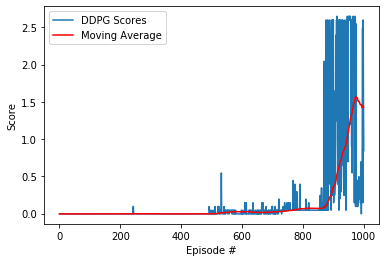

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

In [65]:
start = time.time()

run_scores, run_avgs = ddpg()

end = time.time()
elapsed = (end - start) / 60.0 
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))

Episode 10 (88 sec)	Current Score: 0.10	Mean Score: 1.00	Moving Average Score: 0.71
Episode 20 (264 sec)	Current Score: 2.65	Mean Score: 2.60	Moving Average Score: 1.53
Episode 30 (222 sec)	Current Score: 0.95	Mean Score: 2.60	Moving Average Score: 1.67
Episode 40 (195 sec)	Current Score: 2.65	Mean Score: 2.60	Moving Average Score: 1.67
Episode 50 (231 sec)	Current Score: 2.60	Mean Score: 2.60	Moving Average Score: 1.74
Episode 60 (141 sec)	Current Score: 1.20	Mean Score: 1.00	Moving Average Score: 1.65
Episode 70 (123 sec)	Current Score: 0.25	Mean Score: -0.00	Moving Average Score: 1.56
Episode 80 (124 sec)	Current Score: 1.20	Mean Score: 1.50	Moving Average Score: 1.50
Episode 90 (141 sec)	Current Score: 2.60	Mean Score: 1.30	Moving Average Score: 1.46
Episode 100 (292 sec)	Current Score: 2.65	Mean Score: 2.65	Moving Average Score: 1.57

Environment solved in 0 episodes!	Average Score: 1.57

Elapsed Time: 30.36 mins.


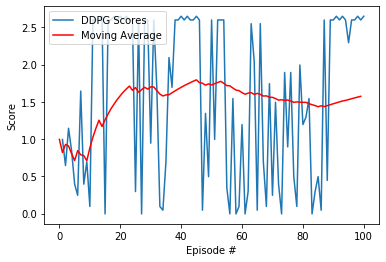

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(run_scores)+1), run_scores, label='DDPG Scores')
plt.plot(np.arange(len(run_scores)), run_avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')

plt.show()

### Watch the smart agent

In [67]:
agent.actor_local.load_state_dict(torch.load('max_checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('max_checkpoint_critic.pth'))

<All keys matched successfully>

In [68]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents) 
episode = 0

for _ in range(6):
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states  
        episode += 1

        if np.any(dones): 
            break 

print('Episodes: {}; Average Score: {}'.
              format(episode, np.mean(scores))) 

UnityActionException: The episode is completed. Reset the environment with 'reset()'

In [12]:
env.close()

# Appendix

In [70]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>